# Imports and Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import torch
import torch.nn as nn
from torch import nn, optim

import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

In [2]:
X, y = make_circles(n_samples=1000, noise=0.03, random_state=42)

In [3]:
len(X), len(y), X[:5], y[:5]

(1000,
 1000,
 array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [4]:
circles = pd.DataFrame({"X1" : X[:, 0], "X2" : X[:, 1], "y" : y})
circles.head()

,X1,X2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


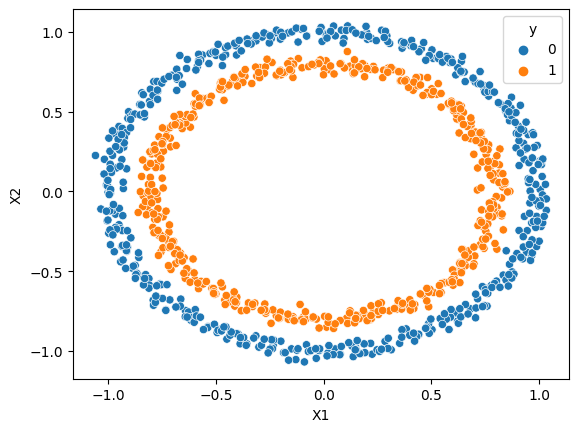

In [5]:
sns.scatterplot(data=circles, x='X1', y='X2', hue='y');

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X : {X_sample} and its shape is {X_sample.shape}")
print(f"Values for one sample of y : {y_sample} and its shape is {y_sample.shape}")

Values for one sample of X : [0.75424625 0.23148074] and its shape is (2,)
Values for one sample of y : 1 and its shape is ()


# Turn Data into Tensors and Creating Train Test Splits

In [8]:
torch.__version__

'2.4.1+cu121'

In [9]:
X.dtype

dtype('float64')

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X.dtype, y.dtype

(torch.float32, torch.float32)

In [11]:
X[:5], y[:5], type(X), type(y)

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]),
 torch.Tensor,
 torch.Tensor)

In [12]:
torch.manual_seed(42)

In [13]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

# Building a model

In [15]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [16]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0()
model_0.to(device)

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
next(model_0.parameters()).device, next(model_0.parameters())

(device(type='cpu'),
 Parameter containing:
 tensor([[ 0.5406,  0.5869],
         [-0.1657,  0.6496],
         [-0.1549,  0.1427],
         [-0.3443,  0.4153],
         [ 0.6233, -0.5188]], requires_grad=True))

# Recreating the same model using nn.Sequential()

In [18]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)
model_0.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
next(model_0.parameters()).device, next(model_0.parameters())

(device(type='cpu'),
 Parameter containing:
 tensor([[-0.0829, -0.2872],
         [ 0.4691, -0.5582],
         [-0.3260, -0.1997],
         [-0.4252,  0.0667],
         [-0.6984,  0.6386]], requires_grad=True))

In [20]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [21]:
# Make predictions (on basic model without training)
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions : {len(untrained_preds)}, Shape : {untrained_preds.shape}")
print(f"Length of test samples : {len(X_test)}, Shape : {X_test.shape}")
print(f"First 10 predictions : {untrained_preds[:5]}")
print(f"First 10 labels : {y_test[:5]}")

Length of predictions : 200, Shape : torch.Size([200, 1])
Length of test samples : 200, Shape : torch.Size([200, 2])
First 10 predictions : tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])
First 10 labels : tensor([1., 0., 1., 0., 1.])



**nn.Sequential(    nn.Sigmoid(),    nn.BCELoss()) is similar to nn.BCEWithLogitsLoss()**


In [22]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [23]:
# Loss and Optimizer 
loss_fn = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(params=model_0.parameters(), lr=0.1)

# Calculate accuracy

In [24]:
torch.eq(torch.tensor([1, 2, 3]), torch.tensor([2, 2, 3]))

tensor([False,  True,  True])

In [25]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    # print(correct, len(y_true), len(y_pred), y_true[:5], y_pred[:5])
    acc = correct/len(y_pred) * 100
    return round(acc, 2)

# Training model

In [26]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [27]:
list(model_0.parameters())

[Parameter containing:
 tensor([[-0.0829, -0.2872],
         [ 0.4691, -0.5582],
         [-0.3260, -0.1997],
         [-0.4252,  0.0667],
         [-0.6984,  0.6386]], requires_grad=True),
 Parameter containing:
 tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], requires_grad=True),
 Parameter containing:
 tensor([-0.1213], requires_grad=True)]

In [28]:
model_0.eval() # Trying out forward pass without training to understand sigmoid use
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))

y_logits[:5]

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [29]:
y_pred_probs = torch.sigmoid(y_logits)
torch.round(y_pred_probs[:5]), y_pred_probs[:5]    # Converts raw logits into probabilities

(tensor([[0.],
         [0.],
         [1.],
         [0.],
         [1.]]),
 tensor([[0.4916],
         [0.4923],
         [0.5223],
         [0.4827],
         [0.5736]]))

In [30]:
# Whole in whole

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))
y_pred_labels.squeeze()[:5]

tensor([0., 0., 1., 0., 1.], grad_fn=<SliceBackward0>)

In [31]:
accuracy_fn(y_test, y_pred_labels.squeeze())

57.5

# Training and Testing Loops

In [32]:
def put_on_device(data, name):
    data = data.to(device)
    print(f"{name} sent to device successfully!")

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

put_on_device(X_train, "X_train")
put_on_device(X_test, "X_test")
put_on_device(y_train, "y_train")
put_on_device(y_test, "y_test")

epochs = 100
for epoch in range(epochs):
    # Training Loop
    model_0.train()
    
    y_preds_logits = model_0(X_train)
    y_preds = torch.round(torch.sigmoid(y_preds_logits))
    
    loss = loss_fn(y_preds_logits.squeeze(), y_train)
    accuracy = accuracy_fn(y_train, y_preds.squeeze())

    if (epoch+1)%5 == 0:
        print(f"\nTraining .... Epoch : {epoch+1} | Loss : {loss} | Accuracy : {accuracy}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Evaluation Loop
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test)
        test_preds = torch.round(torch.sigmoid(test_logits))

        loss = loss_fn(test_logits.squeeze(), y_test)
        accuracy = accuracy_fn(y_test, test_preds.squeeze())
        if (epoch+1)%5 == 0:
            print(f"Testing .... Epoch : {epoch+1} | Loss : {loss} | Accuracy : {accuracy}")

X_train sent to device successfully!
X_test sent to device successfully!
y_train sent to device successfully!
y_test sent to device successfully!

Training .... Epoch : 5 | Loss : 0.6969358325004578 | Accuracy : 51.5
Testing .... Epoch : 5 | Loss : 0.6936988234519958 | Accuracy : 56.0

Training .... Epoch : 10 | Loss : 0.6960405111312866 | Accuracy : 51.25
Testing .... Epoch : 10 | Loss : 0.6931362152099609 | Accuracy : 54.0

Training .... Epoch : 15 | Loss : 0.6954202055931091 | Accuracy : 51.5
Testing .... Epoch : 15 | Loss : 0.6927890777587891 | Accuracy : 51.0

Training .... Epoch : 20 | Loss : 0.6949752569198608 | Accuracy : 51.62
Testing .... Epoch : 20 | Loss : 0.6925751566886902 | Accuracy : 50.5

Training .... Epoch : 25 | Loss : 0.6946452260017395 | Accuracy : 52.0
Testing .... Epoch : 25 | Loss : 0.6924453973770142 | Accuracy : 49.5

Training .... Epoch : 30 | Loss : 0.69439297914505 | Accuracy : 51.0
Testing .... Epoch : 30 | Loss : 0.6923701763153076 | Accuracy : 49.0

Tra

# Helper Functions

In [34]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print("helper_functions.py already exists, skipping download.")
else:
    print("Downloading helper_functions.py")
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as file:
        file.write(request.content)

In [35]:
from helper_functions import plot_decision_boundary, plot_predictions

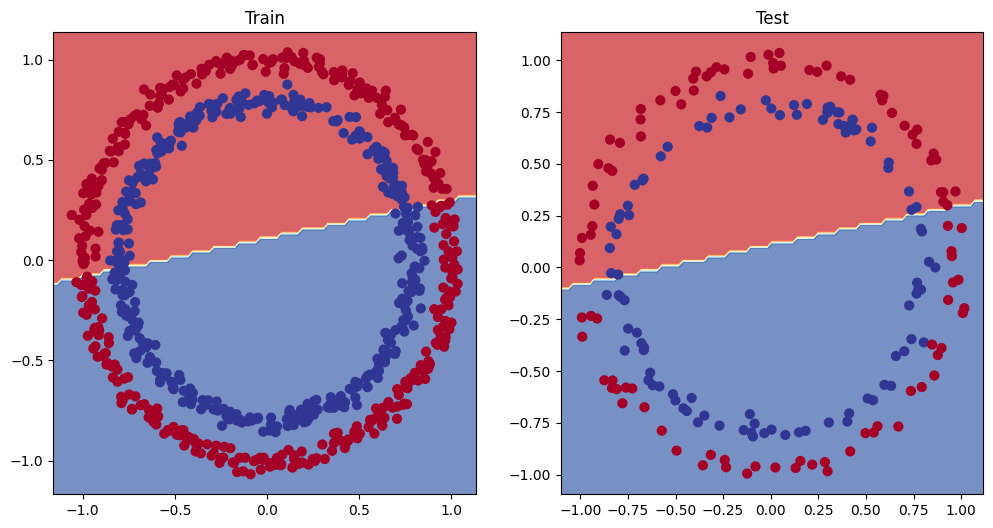

In [36]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Improving a model

* Add more layers
* Add more hidden units
* Fit for longer
* Changing the activation functions
* Changing the learning rate
* Changing the loss function

In [37]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1()
model_1.to(device)

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(params=model_1.parameters(), lr=0.1)

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Training for longer epochs
epochs = 1000

put_on_device(X_train, "X_train")
put_on_device(X_test, "X_test")
put_on_device(y_train, "y_train")
put_on_device(y_test, "y_test")

for epoch in range(epochs):
    model_1.train()
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.001

    y_pred_logits = model_1(X_train)
    y_preds = torch.round(torch.sigmoid(y_pred_logits))

    train_loss = loss_fn(y_pred_logits.squeeze(), y_train)
    train_accuracy = accuracy_fn(y_train, y_preds.squeeze())

        
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()


    # Evaluation Loop
    model_1.eval()
    with torch.inference_mode():
        y_pred_logits = model_1(X_test)
        y_preds = torch.round(torch.sigmoid(y_pred_logits))

        test_loss = loss_fn(y_pred_logits.squeeze(), y_test)
        test_accuracy = accuracy_fn(y_test, y_preds.squeeze())

        if (epoch+1)%50 == 0:
            print(f"Epoch : {epoch+1} | Accuracy : {train_accuracy}% | Test Loss : {test_loss:.5f} | Test Accuracy : {test_accuracy}%")

X_train sent to device successfully!
X_test sent to device successfully!
y_train sent to device successfully!
y_test sent to device successfully!
Epoch : 50 | Accuracy : 50.75% | Test Loss : 0.69261 | Test Accuracy : 51.0%
Epoch : 100 | Accuracy : 50.5% | Test Loss : 0.69261 | Test Accuracy : 51.0%
Epoch : 150 | Accuracy : 50.62% | Test Loss : 0.69262 | Test Accuracy : 50.5%
Epoch : 200 | Accuracy : 50.62% | Test Loss : 0.69262 | Test Accuracy : 50.5%
Epoch : 250 | Accuracy : 50.62% | Test Loss : 0.69262 | Test Accuracy : 50.5%
Epoch : 300 | Accuracy : 50.62% | Test Loss : 0.69263 | Test Accuracy : 50.5%
Epoch : 350 | Accuracy : 50.62% | Test Loss : 0.69263 | Test Accuracy : 50.5%
Epoch : 400 | Accuracy : 50.62% | Test Loss : 0.69263 | Test Accuracy : 51.0%
Epoch : 450 | Accuracy : 50.62% | Test Loss : 0.69264 | Test Accuracy : 50.5%
Epoch : 500 | Accuracy : 50.75% | Test Loss : 0.69264 | Test Accuracy : 50.5%
Epoch : 550 | Accuracy : 50.88% | Test Loss : 0.69265 | Test Accuracy : 51.0

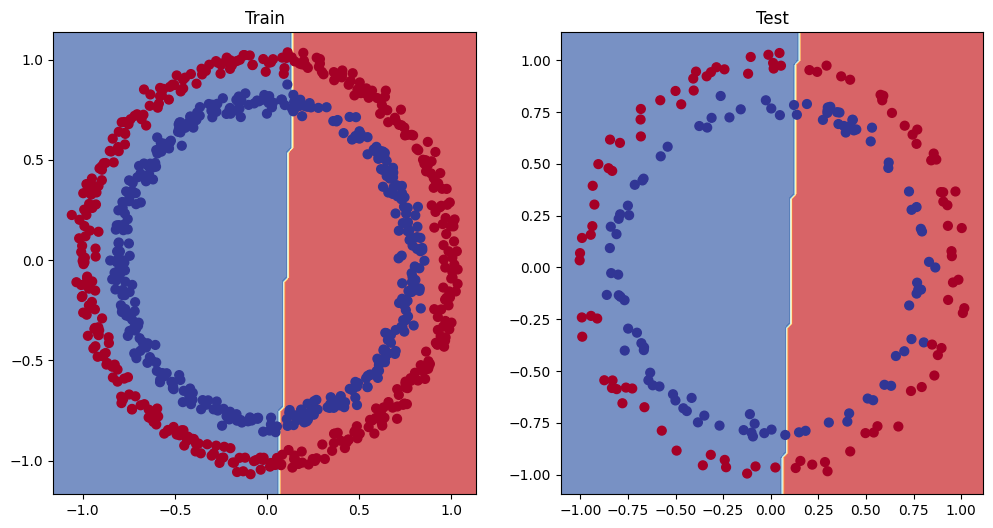

In [40]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# The missing piece - Non Linearity

In [41]:
import torch
from sklearn.model_selection import train_test_split

# X = torch.from_numpy(X).type(torch.float)
# y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [42]:
# Building the model with non linear activation function
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.layer_1(x))))

model_3 = CircleModelV2()
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [43]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(params=model_3.parameters(), lr=0.1)

In [44]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

put_on_device(X_train, "X_train")
put_on_device(X_test, "X_test")
put_on_device(y_train, "y_train")
put_on_device(y_test, "y_test")

epoch_count = []
train_loss = []
train_acc = []
test_loss = []
test_acc = []

epochs = 1000
for epoch in range(epochs):
    model_3.train()

    y_preds_logits = model_3(X_train)
    y_preds = torch.round(torch.sigmoid(y_preds_logits))

    loss_train = loss_fn(y_preds_logits.squeeze(), y_train)
    acc_train = accuracy_fn(y_train, y_preds.squeeze())

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    

    model_3.eval()

    with torch.inference_mode():
        y_preds_logits = model_3(X_test)
        y_preds = torch.round(torch.sigmoid(y_preds_logits))

        loss_test = loss_fn(y_preds_logits.squeeze(), y_test)
        acc_test = accuracy_fn(y_test, y_preds.squeeze())

        if (epoch+1)%100 == 0:
            print(f"Epoch : {epoch+1} | Train Loss : {loss_train} | Train Acc : {acc_train} | Test Loss : {loss_test} | Test Acc : {acc_test}")

X_train sent to device successfully!
X_test sent to device successfully!
y_train sent to device successfully!
y_test sent to device successfully!
Epoch : 100 | Train Loss : 0.007081212941557169 | Train Acc : 100.0 | Test Loss : 0.016835927963256836 | Test Acc : 100.0
Epoch : 200 | Train Loss : 0.0035949330776929855 | Train Acc : 100.0 | Test Loss : 0.011115550994873047 | Test Acc : 100.0
Epoch : 300 | Train Loss : 0.0024675324093550444 | Train Acc : 100.0 | Test Loss : 0.00880077201873064 | Test Acc : 100.0
Epoch : 400 | Train Loss : 0.0020027104765176773 | Train Acc : 100.0 | Test Loss : 0.007752005010843277 | Test Acc : 100.0
Epoch : 500 | Train Loss : 0.0017052626935765147 | Train Acc : 100.0 | Test Loss : 0.007006384897977114 | Test Acc : 100.0
Epoch : 600 | Train Loss : 0.0014925595605745912 | Train Acc : 100.0 | Test Loss : 0.00651936512440443 | Test Acc : 100.0
Epoch : 700 | Train Loss : 0.0013282069703564048 | Train Acc : 100.0 | Test Loss : 0.006032985635101795 | Test Acc : 10

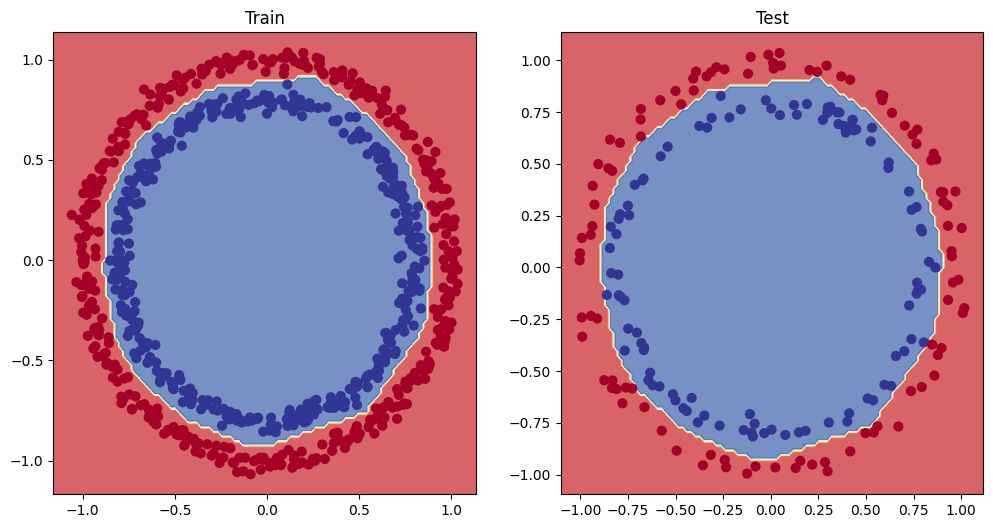

In [45]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

# Coding activation function from scratch

In [46]:
A = torch.arange(-10, 10, 1, dtype=torch.float)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

In [47]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

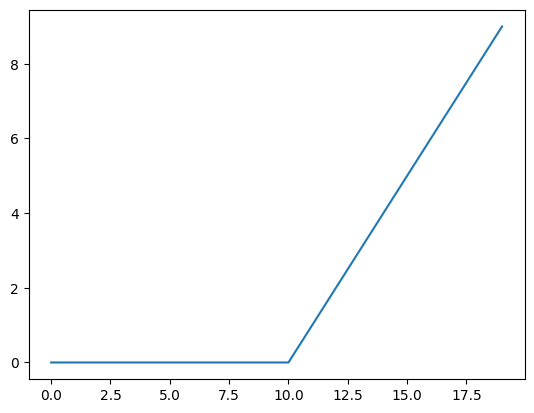

In [48]:
plt.plot(relu(A));

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])


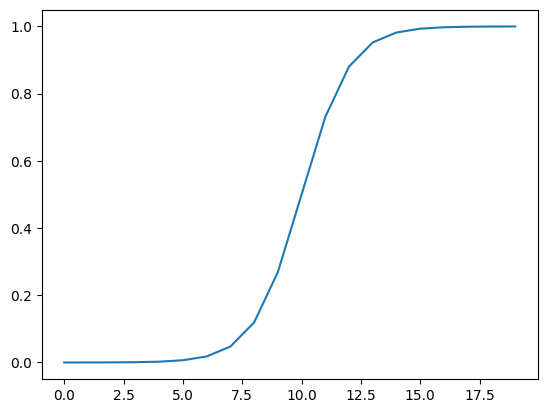

In [49]:
print(torch.sigmoid(A)) # HomeWork
plt.plot(torch.sigmoid(A));

# Multi-Class Classification

In [50]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob,
                                                    test_size=0.2, random_state=RANDOM_SEED)
X_train[:5], y_train[:5]

(tensor([[ 5.0405,  3.3076],
         [-2.6249,  9.5260],
         [-8.5240, -9.0402],
         [-6.0262, -4.4375],
         [-3.3397,  7.2175]]),
 tensor([1., 0., 2., 2., 0.]))

In [51]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

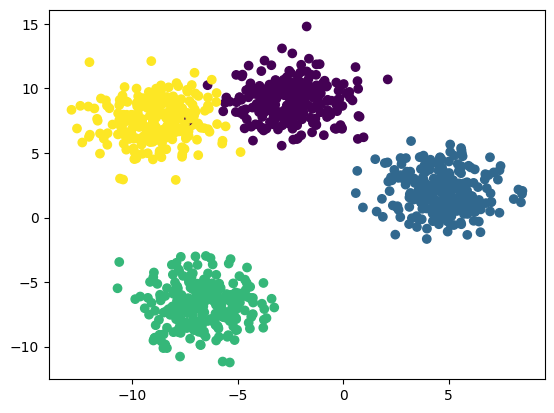

In [52]:
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob);

In [53]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [54]:
class BlobModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_units=8):
        '''
        DocString
        '''
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(in_features=2, out_features=4, hidden_units=8)
model_4.to(device)

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [55]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=model_4.parameters(), lr=0.1)

------

In [56]:
# Raw models predictions to understand the model
with torch.inference_mode():
    y_logits = model_4(X_train)

y_logits[:5]

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]])

In [57]:
y_probs = torch.softmax(y_logits, dim=1)
y_probs[:5]

tensor([[0.3080, 0.3328, 0.1441, 0.2150],
        [0.3577, 0.1324, 0.1696, 0.3402],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3000, 0.1845, 0.2743, 0.2413],
        [0.3424, 0.1450, 0.1936, 0.3190]])

In [58]:
torch.sum(y_probs[0]), torch.sum(y_probs[100]) # Any

(tensor(1.), tensor(1.))

In [59]:
torch.argmax(y_probs[0])

tensor(1)

In [60]:
y_preds = torch.argmax(y_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0,
        3, 0, 3, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
        0, 0, 0, 3, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Creating training and testing loops for multiclass classification

In [61]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

put_on_device(X_train, "X_train")
put_on_device(X_test, "X_test")
put_on_device(y_train, "y_train")
put_on_device(y_test, "y_test")

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_train)
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
    # print(y_logits[:5], y_preds[:5])

    train_loss = loss_fn(y_logits.squeeze(), y_train.long())
    train_acc = accuracy_fn(y_train.long(), y_preds.squeeze())

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()


    model_4.eval()
    with torch.inference_mode():
        y_logits = model_4(X_test)
        y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

        test_loss = loss_fn(y_logits.squeeze(), y_test.long())
        test_acc = accuracy_fn(y_test.long(), y_preds.squeeze())

        if (epoch+1)%100 == 0:
            print(f"Epoch:{epoch+1} | Train Loss : {train_loss} | Train Acc : {train_acc} | Test Loss : {test_loss} | Test Acc : {test_acc}")

X_train sent to device successfully!
X_test sent to device successfully!
y_train sent to device successfully!
y_test sent to device successfully!
Epoch:100 | Train Loss : 0.016000870615243912 | Train Acc : 99.38 | Test Loss : 0.004737615119665861 | Test Acc : 100.0
Epoch:200 | Train Loss : 0.014519545249640942 | Train Acc : 99.38 | Test Loss : 0.0028387384954839945 | Test Acc : 100.0
Epoch:300 | Train Loss : 0.01397521048784256 | Train Acc : 99.38 | Test Loss : 0.002460256451740861 | Test Acc : 100.0
Epoch:400 | Train Loss : 0.013907169923186302 | Train Acc : 99.38 | Test Loss : 0.0026139405090361834 | Test Acc : 100.0
Epoch:500 | Train Loss : 0.014158990234136581 | Train Acc : 99.5 | Test Loss : 0.002848672214895487 | Test Acc : 100.0
Epoch:600 | Train Loss : 0.013792025856673717 | Train Acc : 99.38 | Test Loss : 0.00235306890681386 | Test Acc : 100.0
Epoch:700 | Train Loss : 0.013794724829494953 | Train Acc : 99.38 | Test Loss : 0.0023780674673616886 | Test Acc : 100.0
Epoch:800 | Tr

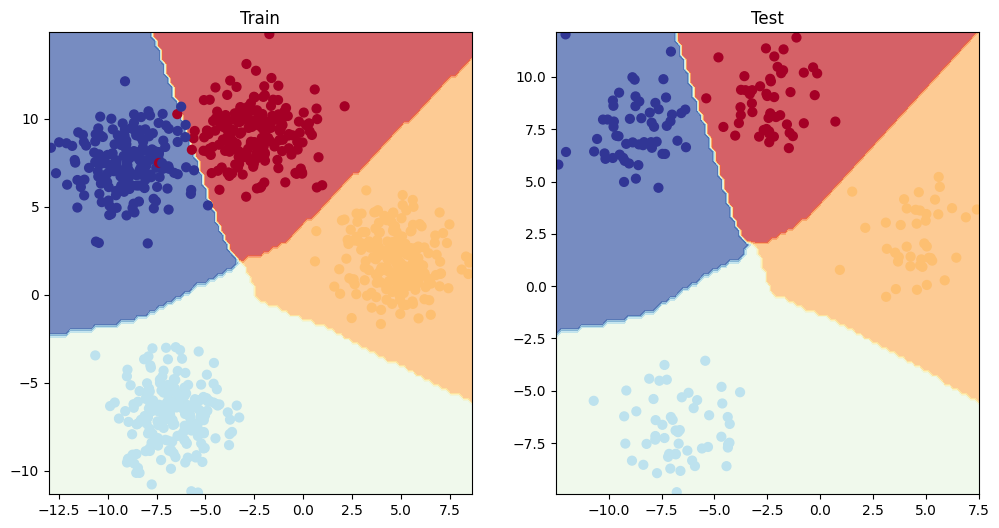

In [62]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)

----

# Random Stuff

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Define a simple dataset
# Features: (2D input), Labels: (3 classes)
X = torch.tensor([[1.0, 2.0], [2.0, 1.0], [1.5, 1.5], [2.5, 3.0], [3.0, 2.5]], dtype=torch.float32)
y = torch.tensor([0, 1, 2, 1, 0], dtype=torch.long)  # Labels for 3 classes (0, 1, 2)

# 2. Define a simple model
class SimpleModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)  # Fully connected layer

    def forward(self, x):
        return self.fc(x)  # Output logits directly

model = SimpleModel(input_size=2, num_classes=3)

# 3. Define loss and optimizer
criterion = nn.CrossEntropyLoss()  # Combines softmax and negative log likelihood
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 4. Train the model for a few steps
epochs = 10
for epoch in range(epochs):
    optimizer.zero_grad()
    logits = model(X)  # Get raw logits
    loss = criterion(logits, y)  # Calculate loss
    loss.backward()  # Backpropagate
    optimizer.step()  # Update weights
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# 5. Get logits and calculate softmax probabilities
with torch.no_grad():
    logits = model(X)
    print("\nLogits (raw outputs):")
    print(logits)

    # Apply softmax to get probabilities
    probabilities = nn.Softmax(dim=1)(logits)  # dim=1 applies softmax across classes
    print("\nProbabilities (after softmax):")
    print(probabilities)

    # Predicted classes
    predicted_classes = torch.argmax(probabilities, dim=1)
    print("\nPredicted Classes:")
    print(predicted_classes)

Epoch 1, Loss: 1.0909
Epoch 2, Loss: 1.0875
Epoch 3, Loss: 1.0844
Epoch 4, Loss: 1.0815
Epoch 5, Loss: 1.0788
Epoch 6, Loss: 1.0763
Epoch 7, Loss: 1.0739
Epoch 8, Loss: 1.0717
Epoch 9, Loss: 1.0697
Epoch 10, Loss: 1.0678

Logits (raw outputs):
tensor([[1.2931, 1.6139, 0.7657],
        [1.2333, 0.8125, 0.4677],
        [1.2632, 1.2132, 0.6167],
        [2.6270, 2.0728, 0.6820],
        [2.5971, 1.6721, 0.5331]])

Probabilities (after softmax):
tensor([[0.3369, 0.4643, 0.1988],
        [0.4713, 0.3095, 0.2192],
        [0.4040, 0.3843, 0.2117],
        [0.5822, 0.3345, 0.0833],
        [0.6564, 0.2603, 0.0833]])

Predicted Classes:
tensor([1, 0, 0, 0, 0])


In [64]:
import torch
import torch.nn as nn

# Raw logits output from model
logits = torch.tensor([0.2, 1.0, -1.0], dtype=torch.float32)
labels = torch.tensor([0, 1, 0], dtype=torch.float32)
sigmoid = nn.Sigmoid()

# Using BCEWithLogitsLoss (sigmoid is applied internally)
bce_logits_loss = nn.BCEWithLogitsLoss()
bce_loss = nn.BCELoss()
loss = bce_logits_loss(logits, labels)
print(f"BCEWithLogitsLoss (Loss value): {loss.item():.4f}")

loss = bce_loss(sigmoid(logits), labels)
print(f"BCELoss (Loss value): {loss.item():.4f}")

# If you want the probabilities, you need to apply sigmoid manually
probabilities = sigmoid(logits)
print(f"Probabilities: {probabilities}")
print(f"Real Logits : {logits}")

BCEWithLogitsLoss (Loss value): 0.4749
BCELoss (Loss value): 0.4749
Probabilities: tensor([0.5498, 0.7311, 0.2689])
Real Logits : tensor([ 0.2000,  1.0000, -1.0000])
